In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logomaker


In [3]:
class MSAAutoencoder(nn.Module):
    def __init__(self, seq_length, latent_dim=2):
        super(MSAAutoencoder, self).__init__()
        self.seq_length = seq_length
        self.latent_dim = latent_dim
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=21,out_channels=64,kernel_size=3,
            padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=32,out_channels=16,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=16,out_channels=latent_dim, kernel_size=3, padding=1), # Cuello de botella
            nn.LayerNorm([latent_dim, seq_length]) #normaliza
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv1d(in_channels=latent_dim, out_channels=16, kernel_size=3,
            padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=16,
            out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=21, kernel_size=3, padding=1),
        )
    
    def forward(self, x):
        x = self.encoder(x) # Extrae representaciones comprimidas
        x = self.decoder(x) # Reconstruye la salida
        return x

a) Escriba un código que permita levantar el alineamiento múltiple y convertirlo a
un tensor de dimensiones número de secuencias (N) x 21 canales (OHE) x longitud del
alineamiento múltiple (L), qué es lo que se va a utilizar como entrada para el entrenamiento en
baches.

In [30]:
def leer_fasta(filepath):
    secuencias = []
    for record in SeqIO.parse(filepath, "fasta"):
        secuencias.append(str(record.seq))
    return secuencias

def one_hot_encoding(secuencias, aminoacidos="ACDEFGHIKLMNPQRSTVWY-"):

    aa_to_index = {aa: idx for idx, aa in enumerate(aminoacidos)}
    ohe_matrices = []
    
    for secuencia in secuencias:
        ohe_matrix = np.zeros((len(aminoacidos), len(secuencia)), dtype=np.float32)
        for i, aa in enumerate(secuencia):
            if aa in aa_to_index:
                ohe_matrix[aa_to_index[aa], i] = 1.0
        ohe_matrices.append(ohe_matrix)
    
    return np.array(ohe_matrices)

def one_hot_to_AA(seq_one_hot, aminoacidos="ACDEFGHIKLMNPQRSTVWY-"):
    aa_to_index = {idx: aa for idx, aa in enumerate(aminoacidos)}
    secuencia = ""
    for i in range(len(seq_one_hot)):
        index = np.argmax(seq_one_hot[:, i])
        secuencia += aa_to_index[index]
    return secuencia

In [34]:
seqs = leer_fasta("NOPQ_cur.fasta")
seqs_one_hot = torch.tensor(one_hot_encoding(seqs), dtype=torch.float32)
print(seqs_one_hot.shape)

torch.Size([2009, 21, 203])


b) Escriba, por otro lado, un módulo(función) que le permita comparar dos secuencias y
calcular su similitud (por ejemplo utilizando una matriz de sustitucion tipo blossum) o identidad,
para evaluar la performance modelo. Recuerde que el autoencoder toma como entrada una
secuencia y genera como salida otra secuencia que debería ser igual a la de la entrada. Por lo
que dadas las N secuencias del MSA hay N pares (input-output) para comparar.

In [27]:
from Bio.Align import substitution_matrices

def calcular_similitud(seq1, seq2, matriz_sustitucion=substitution_matrices.load("BLOSUM62")):
    
    puntaje = 0
    
    for aa1, aa2 in zip(seq1, seq2):
        if (aa1, aa2) in matriz_sustitucion:
            puntaje += matriz_sustitucion[(aa1, aa2)]
        elif (aa2, aa1) in matriz_sustitucion:  # La matriz es simétrica
            puntaje += matriz_sustitucion[(aa2, aa1)]
    
    return puntaje


c) Entonces, primero para un modelo sin entrenar, y luego para diferentes modelos entrenados
corra todas los pares de secuencias con su programa de scoring y realice el histograma
correspondiente. Analice cómo cambia la performance del modelo cuando uno achica la
dimensión latente de 8, a 4, a 2 y hasta uno(1).

In [ ]:
my_nn = MSAAutoencoder(seq_length=seqs_one_hot.shape[2], latent_dim=2)

# Sin entrenar
out = my_nn(seqs_one_hot)
similitud = [[] for _ in range(5)]

for i in range(len(seqs)):
    similitud[0].append(calcular_similitud(seqs[i], one_hot_to_AA(out[i].detach().numpy())))

In [ ]:
def train(network, optimizer, 
          criterion, 
          train_loader = None):
    
    network.train()
    batch_size = train_loader.batch_size
    total_loss = 0

    for batch_i, (data, target) in enumerate(train_loader):
        
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
            
        
    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [43]:
y_true_indices = torch.argmax(seqs_one_hot, dim=1)
dataset = TensorDataset(seqs_one_hot, y_true_indices)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [50]:
dims = [1, 2, 4, 8]
losses = []
epochs = 50
for i,dim in enumerate(dims):
    my_nn = MSAAutoencoder(seq_length=seqs_one_hot.shape[2], latent_dim=dim)
    optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        loss = train(my_nn, optimizer, criterion, dataloader)
        losses.append(loss)
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
    similitud[i+1] = [calcular_similitud(seqs[j], one_hot_to_AA(my_nn(seqs_one_hot[j]).detach().numpy())) for j in range(len(seqs))]


Epoch 10/50, Loss: 0.2934
Epoch 20/50, Loss: 0.2223
Epoch 30/50, Loss: 0.1800
Epoch 40/50, Loss: 0.1479
Epoch 50/50, Loss: 0.1301
Epoch 10/50, Loss: 0.0009
Epoch 20/50, Loss: 0.0001
Epoch 30/50, Loss: 0.2126
Epoch 40/50, Loss: 0.0006
Epoch 50/50, Loss: 0.0002
Epoch 10/50, Loss: 0.0005
Epoch 20/50, Loss: 0.0001
Epoch 30/50, Loss: 0.0009
Epoch 40/50, Loss: 0.0002
Epoch 50/50, Loss: 0.0001
Epoch 10/50, Loss: 0.0011
Epoch 20/50, Loss: 0.0001
Epoch 30/50, Loss: 0.0010
Epoch 40/50, Loss: 0.0002
Epoch 50/50, Loss: 0.0001


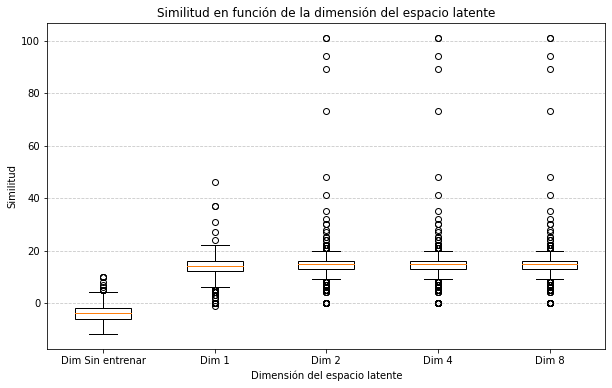

In [58]:
dims = ['Sin entrenar', 1, 2, 4, 8]
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(similitud, labels=[f"Dim {dim}" for dim in dims], patch_artist=True)
for box in boxplot['boxes']:
    box.set(facecolor='white')
plt.title("Similitud en función de la dimensión del espacio latente")
plt.xlabel("Dimensión del espacio latente")
plt.ylabel("Similitud")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Interpretacion del modelo
Ejercicio 72. a) Utilizando el promedio sobre el eje de las diferentes secuencias elija los valores
medios en el espacio latente para generar la distribución de probabilidades de los aminoácidos
en cada posición. Recuerde que la salida del decoder para obtener la distribución de
probabilidades normalizada hay que aplicarle softmax.
Compare la distribución de probabilidades de los aminoácidos en cada posición para un modelo
sin entrenar, y para un modelo entrenado utilizando la media del vector latente de todas las
secuencias. Luego haga lo mismo para cada uno de los grupos N,O,P y si quiere también el
grupo Q.

In [60]:
my_nn.eval()
with torch.no_grad():
    latent_vectors = my_nn.encoder(seqs_one_hot)
latent_vectors.shape

torch.Size([2009, 8, 203])

In [93]:
mu = latent_vectors.mean(dim=0, keepdim=True)
mu.shape

torch.Size([1, 8, 203])

In [94]:
with torch.no_grad():
    decoded = my_nn.decoder(mu)
prob_dist = torch.softmax(decoded, dim=1)
prob_dist.shape

torch.Size([1, 21, 203])

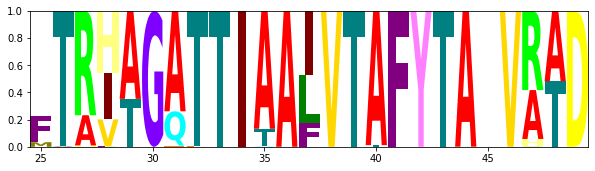

In [97]:
amino_acids = list("ACDEFGHIKLMNPQRSTVWY-")
prob_df = pd.DataFrame(prob_dist.squeeze().numpy().T, columns=amino_acids)
prob_df = prob_df.drop(columns=['-']) # Remove the gap column
prob_df=prob_df.iloc[25:50]
# Define the color scheme
color_scheme = {
'A': '#FF0000', # Red
'R': '#00FF00', # Green
'N': '#0000FF', # Blue
'D': '#FFFF00', # Yellow
'C': '#FF00FF', # Magenta
'Q': '#00FFFF', # Cyan
'E': '#FF8000', # Orange
'G': '#8000FF', # Purple
'H': '#FFFF80', # Light Yellow
'I': '#800000', # Dark Red
'L': '#008000', # Dark Green
'K': '#000080', # Dark Blue
'M': '#808000', # Olive
'F': '#800080', # Dark Magenta
'P': '#808080', # Gray
'S': '#00FF80', # Light Green
'T': '#008080', # Teal
'W': '#FFFFFF', # White
'Y': '#FF80FF', # Pink
'V': '#FFD700', # Gold
'-': '#000000', # Black for gaps
}
# Apply the color scheme to the logo
logo = logomaker.Logo(prob_df, color_scheme=color_scheme)
# Show the logo
plt.show()